# Seq2Seq

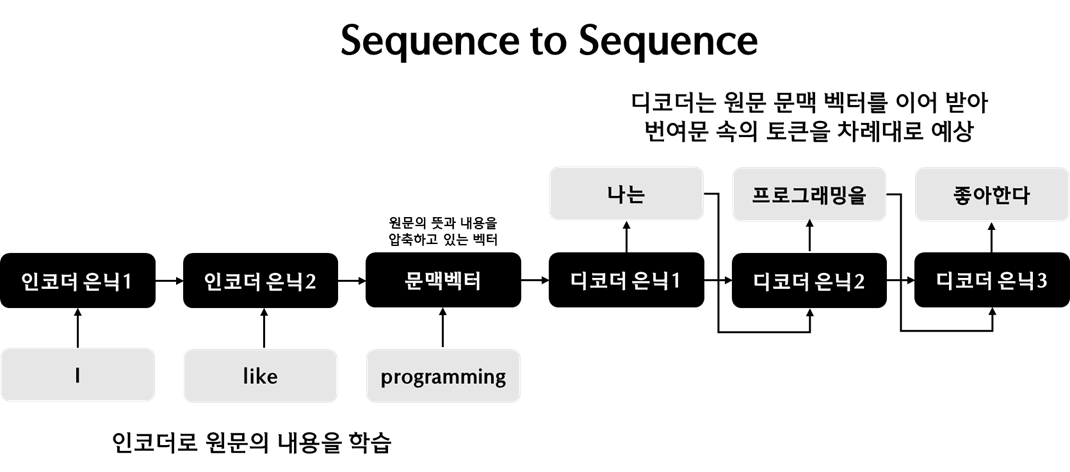


In [37]:
import torch 
import torch.nn as nn
import random
import matplotlib.pyplot as plt

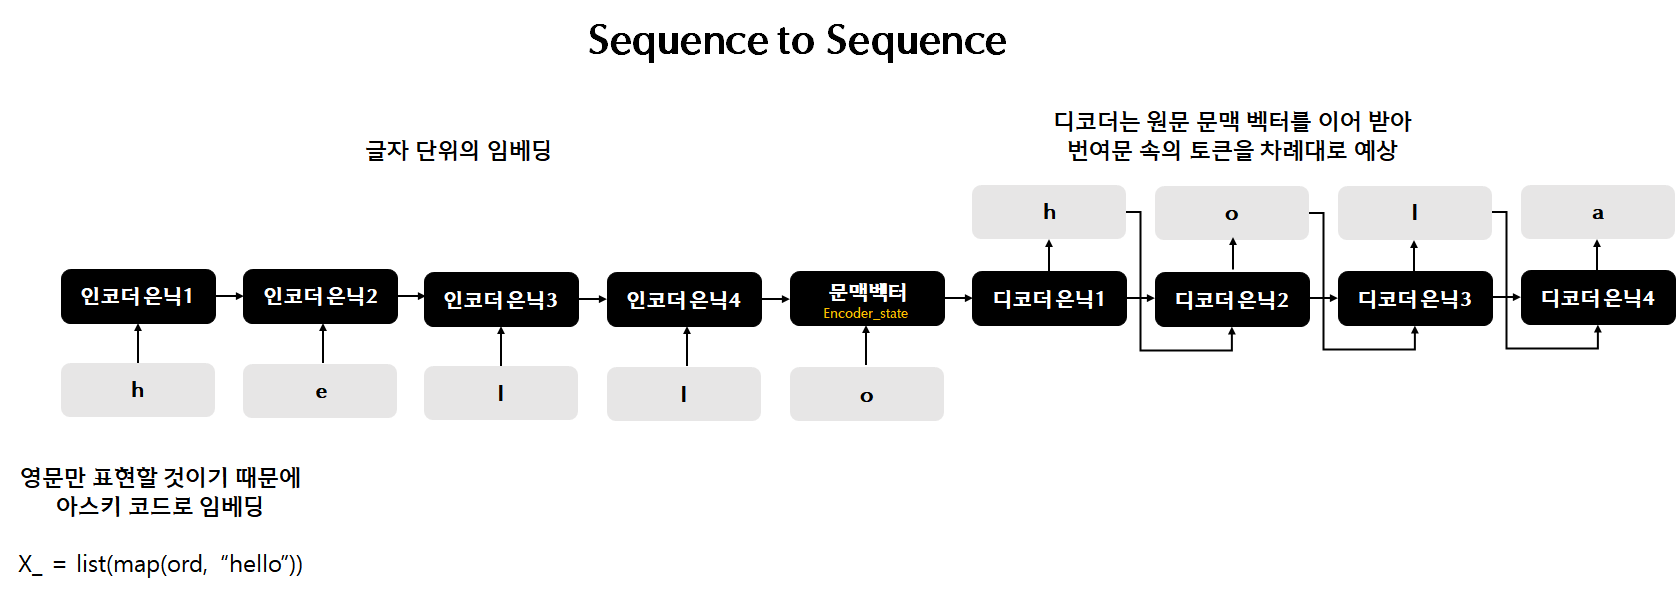


In [38]:
vocab_size = 256 # 총 아스키 코드 

원문과 번역문을 아스키 코드ㅢ 배열로 정의하고 파이토치 첸서로 바꿔야 한다. 

In [39]:
x_ = list(map(ord,"hello")) # 아스키 코드로 변환
y_ = list(map(ord,"hola")) # 아스키 코드로 변환
print("hello -> ", x_)
print("hola -> ", y_)
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

hello ->  [104, 101, 108, 108, 111]
hola ->  [104, 111, 108, 97]


Seq2Seq 모델 클래스 정의
n_layers 는 1로 정의하고 
RNN 의 hidden_size 를 입력바도록 설정 

임베딩 함수 -> 실전에서는 웜누과 번역문의 문자 체계가 완전히 다른 경우 
원문용 임베딩 과 번역문용 임베딩을 따로 만들어야 한다.
하지만 이번 예제에서는 영어와 스펭ㄴ어 모두 아스키 코드로 나타내기 때문에 임베딩을 하나만 만들어도 무방 

  self.project = nn.Linear(hidden_size, vocab_size)
  -> 디코더가 번역문의 다음 토큰을 예상해내는 작은 신경망 정의


In [40]:
class  Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1 
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs, targets):
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1) #원문을 인코더에 임베딩 
        encoder_output, encoder_state = self.encoder(embedding, initial_state) # encoder_state는 문맥벡터
        
        # encoder_state는 문맥벡터 ->디코더의 첫번째 은닉 벡터 decoder_state로 지정
        # 디코더가 번역문의 첫 번째 토큰을 예상하려면 인코더의 문맥 벡터와 문장 시작 토큰을 입력 데이터로 받아야 한다.
        decoder_state = encoder_state
        
        # 디코더에 문장의 시작을 알리기위해 아스키값으로 공백 문자를 뜻하는 0을 
        # ㅇㄴ위적으로 넣느다. 
        decoder_input = torch.LongTensor([0]) 
        
        outputs = []  # 반복 
        for i in range(targets.size()[0]):
            #첫 번째 토큰과 인코더의 문맥벡터 동시 입력 
            decoder_input = self.embedding(decoder_input).unsqueeze(1) 
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            
            #디코더의 결과값을 다시 디코더 모델에 입력 
            projection = self.project(decoder_output)
            # 디코더의 출력값을 신경망의 마지막 층인 Softmax 층을 거치게 한다. 
            outputs.append(projection)
            # -> 디코더의 출력값으로 다음 글자 예측 
            
            # 티처 포싱을 이용한 디코더 입력 갱신 
            # 디코더 학습 시 실제 번역문의 토큰을 디코더의 전 출력값 대신 입력으로 사용해서 학습을 가속
            # 번역문의 i번째 토큰의 해당하는 값 targets[i]를 디코더의 입력값으로 설정
            decoder_input = torch.LongTensor([targets[i]])
        
        
        # 모든 토큰에 대한 결괏값들의 배열 outputs 반환
        outputs = torch.stack(outputs).squeeze() 
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [41]:
seq2seq = Seq2Seq(vocab_size,16)
criterion = nn.CrossEntropyLoss() #교차 엔트로피 오차 
optimizer = torch.optim.Adam(seq2seq.parameters(),lr=1e-3) # 최적화 알고리즘

In [42]:
log = []
for i in range(1000):
    prediction = seq2seq(x,y)
    loss = criterion(prediction,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복 :%d 오차 : %s" %(i,loss_val.item()))
        _, top1 = prediction.data.topk(1,1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])

        


 반복 :0 오차 : 5.469820976257324
['j', '\x06', '×', 'g']

 반복 :100 오차 : 1.7771915197372437
['h', 'o', 'l', 'a']

 반복 :200 오차 : 0.5571564435958862
['h', 'o', 'l', 'a']

 반복 :300 오차 : 0.3116042912006378
['h', 'o', 'l', 'a']

 반복 :400 오차 : 0.2113412618637085
['h', 'o', 'l', 'a']

 반복 :500 오차 : 0.1551753431558609
['h', 'o', 'l', 'a']

 반복 :600 오차 : 0.11944614350795746
['h', 'o', 'l', 'a']

 반복 :700 오차 : 0.0944591760635376
['h', 'o', 'l', 'a']

 반복 :800 오차 : 0.07502326369285583
['h', 'o', 'l', 'a']

 반복 :900 오차 : 0.057872697710990906
['h', 'o', 'l', 'a']


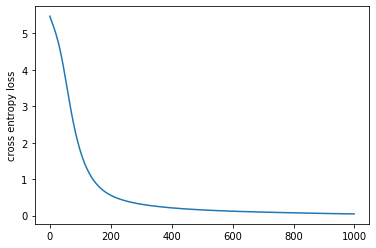

In [43]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()